In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [2]:
from datetime import datetime

df = pd.read_csv('../data/btcusdt.csv', index_col=False)
df['Opentime'] = pd.to_datetime(df['Opentime'])

# cropped out datetime from 2021/12/15 to 2021/12/16
df = df[~(df['Opentime'] < '2021-12-15 00:00:00')]
del df['Ignore']    # remove unused ignored column

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Opentime            2000 non-null   datetime64[ns]
 1   Open                2000 non-null   float64       
 2   High                2000 non-null   float64       
 3   Low                 2000 non-null   float64       
 4   Close               2000 non-null   float64       
 5   Volume              2000 non-null   float64       
 6   Closetime           2000 non-null   int64         
 7   Quote asset volume  2000 non-null   float64       
 8   Number of trades    2000 non-null   int64         
 9   Taker by base       2000 non-null   float64       
 10  Taker buy quote     2000 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 187.5 KB


In [3]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Candlestick(
        x=df['Opentime'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close']
    )]
)
fig.show()

We hence compute the log returns on the closing price of the candlestick.

In [4]:
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,log_returns
0,2022-07-14 14:42:00,19970.23,19976.38,19961.92,19969.78,54.23882,1657780979999,1.083113e+06,2086,25.42902,5.078110e+05,NaN
1,2022-07-14 14:43:00,19969.78,19988.07,19966.83,19981.67,76.44766,1657781039999,1.527254e+06,2569,42.97334,8.585345e+05,0.000595
2,2022-07-14 14:44:00,19979.52,20001.43,19977.89,20000.75,76.81600,1657781099999,1.535827e+06,2402,41.71792,8.341394e+05,0.000954
3,2022-07-14 14:45:00,19998.08,20054.66,19998.07,20041.96,231.96826,1657781159999,4.646698e+06,5870,142.64732,2.857418e+06,0.002058
4,2022-07-14 14:46:00,20041.96,20064.88,20033.21,20036.43,138.45879,1657781219999,2.775858e+06,3948,73.39213,1.471429e+06,-0.000276


In [5]:
#minutes2shift = [1, 2, 5, 10, 15, 30, 60, 120, 240]
minutes2shift = [1, 2, 3, 4, 5]

def generate_lags(data):
    global cols
    cols = []
    for lag in minutes2shift:
        if 'log_returns' in data:
            col = 'lag_{}'.format(lag)
            data[col] = data['log_returns'].shift(lag)
            cols.append(col)
    print(cols)

In [6]:
generate_lags(df)

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']


In [7]:
df.dropna(inplace=True)
corr = pd.DataFrame(df[cols].apply(lambda x: x.corr(df['log_returns'])))
corr

,0
lag_1,0.017356
lag_2,-0.036214
lag_3,-0.009608
lag_4,-0.014211
lag_5,0.008132


In [8]:
df[cols] = np.where(df[cols] > 0, 1, 0)
df['direction'] = np.where(df['log_returns'] > 0, 1, -1)

In [9]:
df[cols + ['direction']].head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
6,1,0,1,1,1,1
7,1,1,0,1,1,1
8,1,1,1,0,1,-1
9,0,1,1,1,0,1
10,1,0,1,1,1,-1


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [67]:
split = int(len(df) * 0.80)
train = df.iloc[:split].copy()
model = SVC(C=1, kernel='poly', degree=3, gamma='scale')
model.fit(train[cols], train['direction'])

SVC(C=1, kernel='poly')

In [68]:
accuracy_score(train['direction'], model.predict(train[cols]))

0.5605015673981191

In [69]:
test = df.iloc[split:].copy()
test['position'] = model.predict(test[cols])

In [70]:
accuracy_score(test['direction'], test['position'])

0.5263157894736842

In [15]:
pd.DataFrame(df, columns=['log_returns'].append(cols))

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,log_returns,lag_1,lag_2,lag_3,lag_4,lag_5,direction
6,2022-07-14 14:48:00,20039.11,20053.74,20034.72,20043.57,68.04419,1657781339999,1.363889e+06,2588,39.88645,7.995213e+05,0.000343,1,0,1,1,1,1
7,2022-07-14 14:49:00,20043.57,20056.59,20039.58,20047.60,73.55722,1657781399999,1.474731e+06,2369,31.40819,6.297078e+05,0.000201,1,1,0,1,1,1
8,2022-07-14 14:50:00,20050.74,20051.00,20021.68,20029.26,67.04852,1657781459999,1.343318e+06,2572,27.68996,5.547521e+05,-0.000915,1,1,1,0,1,-1
9,2022-07-14 14:51:00,20029.26,20053.75,20026.11,20047.43,59.57048,1657781519999,1.193983e+06,2499,31.76897,6.367680e+05,0.000907,0,1,1,1,0,1
10,2022-07-14 14:52:00,20044.85,20047.52,20024.39,20033.29,87.06491,1657781579999,1.744263e+06,2881,39.27311,7.867874e+05,-0.000706,1,0,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2022-07-15 23:56:00,20851.75,20854.06,20830.30,20839.44,59.04577,1657900619999,1.230599e+06,2489,30.08875,6.271038e+05,-0.000591,1,0,1,0,0,-1
1996,2022-07-15 23:57:00,20841.31,20842.00,20812.00,20814.05,56.00447,1657900679999,1.166369e+06,2358,24.57709,5.118785e+05,-0.001219,0,1,0,1,0,-1
1997,2022-07-15 23:58:00,20814.05,20817.98,20783.89,20788.67,246.16047,1657900739999,5.119846e+06,4757,99.75851,2.074993e+06,-0.001220,0,0,1,0,1,-1
1998,2022-07-15 23:59:00,20785.52,20803.22,20777.00,20792.19,110.59637,1657900799999,2.299633e+06,3442,59.21621,1.231400e+06,0.000169,0,0,0,1,0,1


<AxesSubplot:xlabel='lag_1', ylabel='lag_2'>

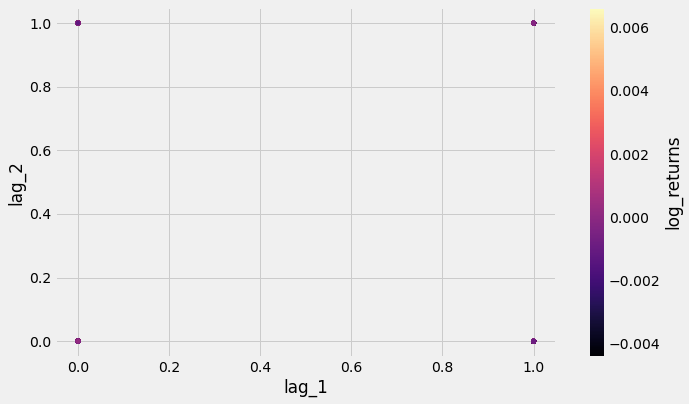

In [16]:
df.plot.scatter(x='lag_1', y='lag_2', c='log_returns',
    cmap='magma', figsize=(10,6), colorbar=True)

In [17]:
df['direction'] = np.sign(df['log_returns']).astype(int)
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,log_returns,lag_1,lag_2,lag_3,lag_4,lag_5,direction
6,2022-07-14 14:48:00,20039.11,20053.74,20034.72,20043.57,68.04419,1657781339999,1.363889e+06,2588,39.88645,799521.279465,0.000343,1,0,1,1,1,1
7,2022-07-14 14:49:00,20043.57,20056.59,20039.58,20047.60,73.55722,1657781399999,1.474731e+06,2369,31.40819,629707.777310,0.000201,1,1,0,1,1,1
8,2022-07-14 14:50:00,20050.74,20051.00,20021.68,20029.26,67.04852,1657781459999,1.343318e+06,2572,27.68996,554752.138825,-0.000915,1,1,1,0,1,-1
9,2022-07-14 14:51:00,20029.26,20053.75,20026.11,20047.43,59.57048,1657781519999,1.193983e+06,2499,31.76897,636767.969664,0.000907,0,1,1,1,0,1
10,2022-07-14 14:52:00,20044.85,20047.52,20024.39,20033.29,87.06491,1657781579999,1.744263e+06,2881,39.27311,786787.379279,-0.000706,1,0,1,1,1,-1


In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [19]:
df['pos_ols_1'] = model.fit(df[cols],
                    df['log_returns']).predict(df[cols])

In [20]:
df['pos_ols_2'] = model.fit(df[cols],
                    df['direction']).predict(df[cols])

In [21]:
df[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
6,0.000012,-0.099365
7,-0.000040,-0.171811
8,0.000032,-0.094336
9,-0.000018,-0.015550
10,0.000012,-0.099365


In [22]:
res = pd.DataFrame(df['log_returns'] - df['pos_ols_1'])
res

,0
6,0.000330
7,0.000241
8,-0.000947
9,0.000925
10,-0.000718
...,...
1995,-0.000667
1996,-0.001186
1997,-0.001290
1998,0.000165


In [23]:
import plotly.express as px

fig = px.scatter_3d(df, x='lag_1', y='lag_2', z='log_returns', color='Close', symbol='direction')
fig.show()

The real value predictions are then transformed to directional values, either -1 or +1.

In [24]:
df[['pos_ols_1', 'pos_ols_2']] = np.where(df[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [25]:
df['pos_ols_1'].value_counts()

 1    1389
-1     605
Name: pos_ols_1, dtype: int64

In [26]:
df['pos_ols_2'].value_counts()

-1    999
 1    995
Name: pos_ols_2, dtype: int64

In [27]:
df['strat_ols_1'] = df['pos_ols_1'] * df['log_returns']
df['strat_ols_2'] = df['pos_ols_2'] * df['log_returns']

Now we can plot out the performance of BTC-USD and regression-based strategies over time.

<AxesSubplot:>

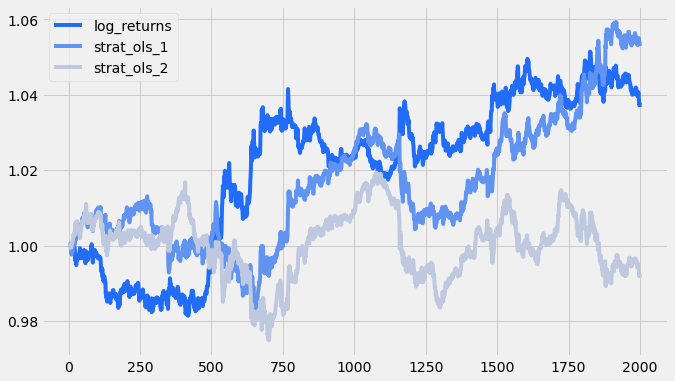

In [28]:
color_dict = {
    'log_returns': '#216DFA',
    'strat_ols_1': '#6193F0',
    'strat_ols_2': '#BEC9DF'
}
column_name = ['log_returns', 'strat_ols_1', 'strat_ols_2']

df[column_name].cumsum().apply(np.exp).plot(color=[color_dict.get(x) for x in column_name], figsize=(10,6))

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [30]:
svm_model = SVC(C=2, kernel='linear', gamma='auto')

In [31]:
split = int(len(df) * 4 / 5)
split

1595

In [32]:
train = df.iloc[:split].copy()
train

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,...,lag_1,lag_2,lag_3,lag_4,lag_5,direction,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
6,2022-07-14 14:48:00,20039.11,20053.74,20034.72,20043.57,68.04419,1657781339999,1.363889e+06,2588,39.88645,...,1,0,1,1,1,1,1,-1,0.000343,-0.000343
7,2022-07-14 14:49:00,20043.57,20056.59,20039.58,20047.60,73.55722,1657781399999,1.474731e+06,2369,31.40819,...,1,1,0,1,1,1,-1,-1,-0.000201,-0.000201
8,2022-07-14 14:50:00,20050.74,20051.00,20021.68,20029.26,67.04852,1657781459999,1.343318e+06,2572,27.68996,...,1,1,1,0,1,-1,1,-1,-0.000915,0.000915
9,2022-07-14 14:51:00,20029.26,20053.75,20026.11,20047.43,59.57048,1657781519999,1.193983e+06,2499,31.76897,...,0,1,1,1,0,1,-1,-1,-0.000907,-0.000907
10,2022-07-14 14:52:00,20044.85,20047.52,20024.39,20033.29,87.06491,1657781579999,1.744263e+06,2881,39.27311,...,1,0,1,1,1,-1,1,-1,-0.000706,0.000706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,2022-07-15 17:17:00,20931.54,20985.00,20929.32,20939.26,184.67739,1657876679999,3.870484e+06,5245,105.41258,...,1,1,0,0,1,1,1,-1,0.000369,-0.000369
1597,2022-07-15 17:18:00,20936.97,20973.61,20935.88,20962.43,114.24280,1657876739999,2.394235e+06,3745,56.11233,...,1,1,1,0,0,1,1,1,0.001106,0.001106
1598,2022-07-15 17:19:00,20963.82,21001.00,20945.21,20990.17,313.09656,1657876799999,6.567789e+06,6793,193.76585,...,1,1,1,1,0,1,-1,-1,-0.001322,-0.001322
1599,2022-07-15 17:20:00,20990.17,21016.25,20960.60,20976.98,289.57584,1657876859999,6.077143e+06,6207,166.74230,...,1,1,1,1,1,-1,-1,-1,0.000629,0.000629


In [33]:
svm_model.fit(train[cols], train['direction'])

SVC(C=2, gamma='auto', kernel='linear')

In [34]:
accuracy_score(train['direction'], svm_model.predict(train[cols]))

0.5360501567398119

<AxesSubplot:>

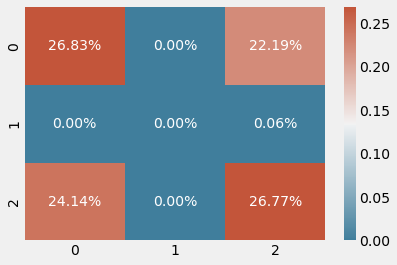

In [35]:
train_cfmatrix = confusion_matrix(train['direction'], svm_model.predict(train[cols]))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_cfmatrix / np.sum(train_cfmatrix), annot=True, fmt='.2%', cmap=cmap)

In [36]:
test = df.iloc[split:].copy()
test['position'] = svm_model.predict(test[cols])

In [37]:
accuracy_score(test['direction'], test['position'])

0.49122807017543857

<AxesSubplot:>

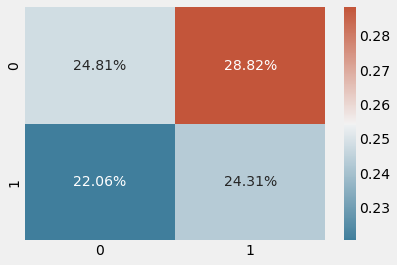

In [38]:
test_cfmatrix = confusion_matrix(test['direction'], test['position'])
sns.heatmap(test_cfmatrix / np.sum(test_cfmatrix), annot=True, fmt='.2%', cmap=cmap)

In [39]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data: pd.DataFrame, period: int):
    rolling_mean = data.rolling(period).mean()
    rolling_std = data.rolling(period).std()

    # Plot rolling statistics
    fig = plt.figure(figsize=(10,6))
    original = plt.plot(data, color='#d0cbc9', label='Original', alpha=0.5)
    mean = plt.plot(rolling_mean, color='#f84c1e', label='Rolling mean', alpha=0.6, linewidth=2.85)
    std_dev = plt.plot(rolling_std, color='#595d66', label='Rolling std', linewidth=2.85)
    plt.legend(loc='best')
    plt.title('Rolling mean & std deviation')
    plt.show()

    # use Akaike Information Criterion
    test = adfuller(data, autolag='AIC')
    print('Augmented Dickey-Fuller test summary:')
    output = pd.Series(test[:4], index=[
                'Test statistic',
                'p-value',
                'Num of lags used',
                'Num of observations'])
    
    for key, value in test[4].items():
        output[f'Critical value ({key})'] = value
    print(output)

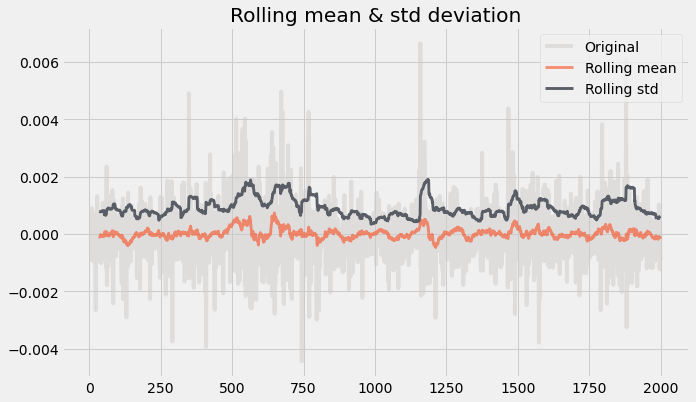

Augmented Dickey-Fuller test summary:
Test statistic           -32.417955
p-value                    0.000000
Num of lags used           1.000000
Num of observations     1992.000000
Critical value (1%)       -3.433637
Critical value (5%)       -2.862992
Critical value (10%)      -2.567543
dtype: float64


In [40]:
test_stationarity(df['log_returns'], 30)

In [41]:
import statsmodels.api as sm

/home/cypeh/anaconda3/envs/ml-binance/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



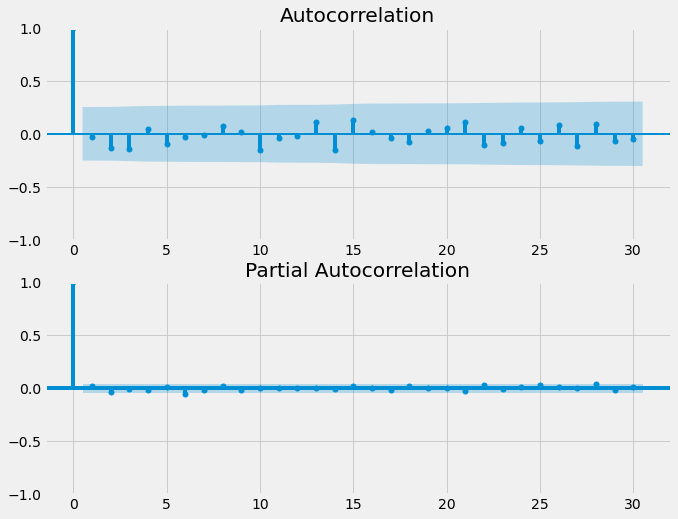

In [42]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['log_returns'].iloc[:60], lags=30, linewidth=2, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['log_returns'], lags=30, ax=ax2)

In [43]:
model = sm.tsa.arima.ARIMA(df['log_returns'], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

/home/cypeh/anaconda3/envs/ml-binance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/cypeh/anaconda3/envs/ml-binance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/cypeh/anaconda3/envs/ml-binance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 1994
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10998.202
Date:                Mon, 25 Jul 2022   AIC                         -21988.405
Time:                        21:22:12   BIC                         -21966.013
Sample:                             0   HQIC                        -21980.182
                               - 1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.771e-05   2.28e-05      0.777      0.437   -2.69e-05    6.24e-05
ar.L1         -0.1747      0.008    -20.579      0.000      -0.191      -0.158
ma.L1          0.1924      0.009     22.598      0.0

/home/cypeh/anaconda3/envs/ml-binance/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## References

- [Huiwen., Wenyang., Shanshan.(2021, March 31), Forecasting open-high-low-close data contained in candlestick chart](https://arxiv.org/pdf/2104.00581.pdf)
- [Gerald. M, (2019, April 25). Advanced candlesticks for machine learning(i): tick bars](https://towardsdatascience.com/advanced-candlesticks-for-machine-learning-i-tick-bars-a8b93728b4c5)